In [ ]:
!brew install pip
%pip install "bayesian-optimization==1.3.1"  --quiet
%pip install lightning  --quiet
%pip install scikit-learn torchvision numpy seaborn  --quiet
%pip install transformers --quiet
%pip install pandas
%pip install timm
%pip install -U tensorboardX
%pip install -U 'tensorboard'

==> Downloading https://formulae.brew.sh/api/formula.jws.json
==> Downloading https://formulae.brew.sh/api/cask.jws.json
pip is part of the python formula:
  brew install python
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use 

In [1]:

import pandas as pd
import os
import multiprocessing as mp

# Then import other libraries and define your code
import random
from collections import defaultdict, Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, average_precision_score
from sklearn.metrics import multilabel_confusion_matrix as ConfusionMatrix
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from transformers import get_cosine_schedule_with_warmup
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

import lightning.pytorch as pl
from lightning.pytorch import Trainer
from lightning.pytorch.strategies import DDPStrategy
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, MulticlassF1Score
from torchmetrics.classification import BinaryPrecisionRecallCurve

from bayes_opt import BayesianOptimization
from tqdm import tqdm
import timm


from torchvision.models import resnet50, ResNet50_Weights



/Users/beszabo/Documents/meme/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y


In [5]:
from sklearn.metrics import precision_recall_curve


class ResNetWrapper(pl.LightningModule):
    def __init__(self, lr, dropout_rate = 0.5):
        super().__init__()
        self.lr = lr
        self.dropout_rate   = dropout_rate  
        self.register_buffer('sigmoid_thresholds', torch.ones(80) * 0.5)  # Initial 0.5 for all classes         self.validation_step_y_hats = []

        # Data collection for threshold tuning
        self.validation_logits = []
        self.validation_targets = []

        # testing
        self.validation_step_ys = []

        backbone = timm.create_model('seresnet152d', pretrained=True, num_classes=80)
        layers = list(backbone.children())[:-1]
        layers.insert(-1, SEBlock(in_channels=2048))  # Insert FIRST
        self.feature_extractor = nn.Sequential(*layers)  # Then create
        # In __init__
        assert isinstance(self.feature_extractor[-2], SEBlock), "SEBlock not in model!"


        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        layers.insert(-1, SEBlock(in_channels=2048))  # 2048 az utolsó réteg csatornáinak száma ResNet50 esetén

        self.classifier = nn.Sequential(
            nn.Dropout(self.dropout_rate), # hyperparameter
            nn.Linear(backbone.fc.in_features, out_features=80)
        )
        
        self.loss_fn = nn.BCEWithLogitsLoss()

        self.train_acc = Accuracy(task="multilabel",num_labels=80)
        self.val_acc = Accuracy(task="multilabel",num_labels=80)
        self.train_precision = Precision(task="multilabel",num_labels=80)
        self.val_precision = Precision(task="multilabel",num_labels=80)
        self.train_recall = Recall(task="multilabel",num_labels=80)
        self.val_recall = Recall(task="multilabel",num_labels=80)
        self.train_f1 = F1Score(task="multilabel",num_labels=80)
        self.val_f1 = F1Score(task="multilabel",num_labels=80)


    def forward(self, x):
        x = self.feature_extractor(x) 
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

    def _get_preds(self, logits):
        """Per-class thresholding with device alignment"""
        return torch.sigmoid(logits) > self.sigmoid_thresholds.to(logits.device)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        
        # Use current thresholds for validation metrics
        preds = self._get_preds(logits)

        # Update metrics
        self.train_acc.update(preds, y)
        self.train_precision.update(preds, y)
        self.train_recall.update(preds, y)
        self.train_f1.update(preds, y)
        self.log('train_acc', self.train_acc)
        self.log('train_precision', self.train_precision)
        self.log('train_recall', self.train_recall)
        self.log('train_f1', self.train_f1)
        
        return loss
    def on_train_epoch_end(self):
        # Reset training metrics at the end of the epoch
        self.train_acc.reset()
        self.train_precision.reset()
        self.train_recall.reset()
        self.train_f1.reset()

        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        
        # Store correctly
        self.validation_logits.append(logits.detach().cpu())
        self.validation_targets.append(y.detach().cpu())
        
        # Compute metrics
        preds = self._get_preds(logits)
        self.val_acc.update(preds, y)
        self.val_precision.update(preds, y)
        self.val_recall.update(preds, y)
        self.val_f1.update(preds, y)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True, on_step=False)
        return {"val_loss": loss}

    

            
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = self._get_preds(logits)
    
        self.log("test_preds", preds)
        self.log("test_targets", y)

    
        self.validation_step_y_hats.append(preds.cpu())
        self.validation_step_ys.append(y.cpu())
        return {'preds': preds, 'targets': y}

            
    def on_validation_epoch_end(self):
        if self.validation_logits:
            all_logits = torch.cat(self.validation_logits, dim=0)  # Ensure batch stacking
            all_targets = torch.cat(self.validation_targets, dim=0)
            new_thresholds = self._calculate_optimal_thresholds(all_logits, all_targets)
            
            # Use in-place assignment instead of `.copy_()` to avoid issues
            self.sigmoid_thresholds = (0.7 * self.sigmoid_thresholds + 0.3 * new_thresholds).detach()

            # Log the average threshold
            self.log('avg_threshold', torch.mean(self.sigmoid_thresholds).item(), prog_bar=True)

            # Clear buffers
            self.validation_logits.clear()
            self.validation_targets.clear()

        # Log metrics
        self.log('val_acc', self.val_acc.compute(), on_epoch=True, prog_bar=True)
        self.log('val_precision', self.val_precision.compute(), on_epoch=True, prog_bar=True)
        self.log('val_recall', self.val_recall.compute(), on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1.compute(), on_epoch=True, prog_bar=True)

        # Reset metrics
        self.val_acc.reset()
        self.val_precision.reset()
        self.val_recall.reset()
        self.val_f1.reset()

    def _calculate_optimal_thresholds(self, logits, targets):
        """Core threshold optimization logic"""
        probs = torch.sigmoid(logits).cpu().numpy()
        targets = targets.cpu().numpy()
        thresholds = np.full(probs.shape[1], 0.5)  # Default to 0.5
        print(f"Min prob per class: {probs.min(axis=0)}")
        print(f"Max prob per class: {probs.max(axis=0)}")

        for i in range(probs.shape[1]):

            if np.sum(targets[:, i]) == 0:
                print(f"Warning: No positive samples for class {i}, keeping threshold at 0.5")
                continue  # Skip threshold tuning for this class

            try:
                # Precision-recall curve with F1 optimization
                precision, recall, threshs = precision_recall_curve(targets[:, i], probs[:, i])
                f1_scores = (2 * precision * recall) / (precision + recall + 1e-8)
                best_idx = np.nanargmax(f1_scores)

                if best_idx < len(threshs):  
                    thresholds[i] = threshs[best_idx]
            except Exception as e:
                print(f"Error computing threshold for class {i}: {e}")

        return torch.tensor(thresholds, device=self.device, dtype=torch.float32)

    def on_epoch_start(self):
        current_lr = self.optimizers().param_groups[0]['lr']
        self.log('lr', current_lr, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        # Total number of training steps (epochs * steps_per_epoch)
        total_training_steps = (
            len(self.trainer.datamodule.train_dataloader()) // self.trainer.world_size
        ) * self.trainer.max_epochs
        warmup_steps = int(0.1 * total_training_steps)  # 10% of total steps for warmup
        
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, 
            num_warmup_steps=warmup_steps, 
            num_training_steps=total_training_steps
        )
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]



Best threshold: 0.3527
Best validation loss: 0.0591

## train test split

In [6]:

def target_to_oh(target):
    NUM_CLASSES = 80  # Number of classes
    one_hot = torch.zeros(NUM_CLASSES)  # Create a tensor of zeros with shape (NUM_CLASSES,)
    one_hot[target] = 1  # Set the correct class index to 1
    return one_hot




def create_train_test_split_proportional(dataset, test_ratio=0.1, seed=42, transform=None):
    """
    Create a train-test split proportional to the dataset's labels.

    Args:
        dataset (ImageFolder): The dataset to split.
        test_ratio (float): Proportion of the dataset to include in the test split.
        seed (int): Random seed for reproducibility.
        transform: Image transformation for preprocessing.

    Returns:
        train_dataset, test_dataset, idx_to_label: The train/test split datasets and label mapping.
    """
    random.seed(seed)

    # Group samples by label
    label_to_samples = defaultdict(list)
    for sample in dataset.samples:
        label_to_samples[sample[1]].append(sample)

    train_samples = []
    test_samples = []

    # Split the dataset into train and test samples
    for label, samples in label_to_samples.items():
        random.shuffle(samples)
        num_test = int(len(samples) * test_ratio)
        test_samples.extend(samples[:num_test])
        train_samples.extend(samples[num_test:])

    # Create ImageFolder datasets for train and test
    train_dataset = ImageFolder(dataset.root, transform=transform)
    train_dataset.samples = train_samples
    train_dataset.targets = [sample[1] for sample in train_samples]  # Update targets

    test_dataset = ImageFolder(dataset.root, transform=transform)
    test_dataset.samples = test_samples
    test_dataset.targets = [sample[1] for sample in test_samples]  # Update targets

    # Use the class_to_idx from the original dataset for label mapping
    idx_to_label = {v: k for k, v in dataset.class_to_idx.items()}

    return train_dataset, test_dataset, idx_to_label


class MyDataModule(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_dataset = None, batch_size=32, num_workers=4, persistent_workers=True):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.persistent_workers = persistent_workers

    def train_dataloader(self):
        train_dataset_with_transform = [(x, target_to_oh(y)) for x, y in self.train_data]
  
        train_loader = DataLoader(train_dataset_with_transform, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, persistent_workers = self.persistent_workers)
     
        return train_loader


    def val_dataloader(self):
        val_dataset_with_transform = [(x, target_to_oh(y)) for x, y in self.val_data]
        val_loader = torch.utils.data.DataLoader(
                    val_dataset_with_transform, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers = self.persistent_workers)

        return val_loader        
    def test_dataloader(self):
        test_dataset_with_transform = [x for x in self.test_data]  # Csak képeket tárolunk
        print(len(test_dataset_with_transform))
        return DataLoader(test_dataset_with_transform, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.persistent_workers)


In [7]:
transform_ = transforms.Compose([ 
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Apply exclusions
dataset = ImageFolder('125images', transform=None)
print(f"Original dataset size: {len(dataset)}")


# Create the train-test split and update label mapping
train_dataset, test_dataset, idx_to_label = create_train_test_split_proportional(dataset, test_ratio=0.08, seed=42, transform=transform_)
print()
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}", '\n')
print("Unique class indices in dataset:", set([sample[1] for sample in dataset.samples]), '\n')
print("Number of unique classes:", len(set([sample[1] for sample in dataset.samples])), '\n')
print("Train label distribution:", Counter([sample[1] for sample in train_dataset.samples]), '\n')
print("Test label distribution:", Counter([sample[1] for sample in test_dataset.samples]), '\n')


Original dataset size: 10000

Train dataset size: 9200
Test dataset size: 800 

Unique class indices in dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79} 

Number of unique classes: 80 

Train label distribution: Counter({0: 115, 1: 115, 2: 115, 3: 115, 4: 115, 5: 115, 6: 115, 7: 115, 8: 115, 9: 115, 10: 115, 11: 115, 12: 115, 13: 115, 14: 115, 15: 115, 16: 115, 17: 115, 18: 115, 19: 115, 20: 115, 21: 115, 22: 115, 23: 115, 24: 115, 25: 115, 26: 115, 27: 115, 28: 115, 29: 115, 30: 115, 31: 115, 32: 115, 33: 115, 34: 115, 35: 115, 36: 115, 37: 115, 38: 115, 39: 115, 40: 115, 41: 115, 42: 115, 43: 115, 44: 115, 45: 115, 46: 115, 47: 115, 48: 115, 49: 115, 50: 115, 51: 115, 52: 115, 53: 115, 54: 115, 55: 115, 56: 115, 57: 1

## training

In [8]:
lr = 0.007323
# threshold=0.4796

batch_size= 23
dropout_rate=0.3


# szarnyprobalgatasok


In [7]:
np.array([train_dataset[i][1] for i in range(len(train_dataset))])

array([ 0,  0,  0, ..., 79, 79, 79], shape=(9200,))

In [8]:
# KFold Cross-Validation
#lr = 0.008274600824983372
#threshold = 0.3527

# or 0.3395    es batch 51
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.naive_bayes import LabelBinarizer
lb = LabelBinarizer()

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
val_losses = []

# Assuming you have `train_dataset` defined as an ImageFolder dataset
for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(train_dataset)) ,lb.fit_transform(np.array([train_dataset[i][1] for i in range(len(train_dataset))])))):
    print(f"Fold {fold + 1}/{kf.n_splits}")


    # Split the dataset into train and validation subsets using indices
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    # Create Data Module for each fold
    data_module = MyDataModule(train_subset, val_subset, batch_size, num_workers=4, persistent_workers=True)

    # Setup the model for multilabel classification
    model = ResNetWrapper(lr=lr, dropout_rate=dropout_rate)

    # Logger
    logger = TensorBoardLogger("finals", name=f"per_class_threshold_updated_{fold}")

    # ModelCheckpoint to save only the best models (monitor F1 score for multilabel)
    checkpoint_callback = ModelCheckpoint(
        monitor="val_f1",  # Monitor validation F1 score
        mode="max",        # Maximize the F1 score
        save_top_k=1,      # Save only the best model
        filename="{epoch}-{val_f1:.4f}"
    )

    # EarlyStopping based on F1 score
    early_stopping = EarlyStopping(
        monitor="val_f1",  # Use F1 for stopping
        patience=3,        # Stop after 3 non-improving epochs
        mode="max"
    )

    # Setup the Trainer
    trainer = Trainer(
        logger=logger,
        max_epochs=20,
        devices='auto',  # Adjust based on your hardware
        accelerator="mps",  # Use "gpu" or "tpu" based on availability
        callbacks=[early_stopping, checkpoint_callback], fast_dev_run=False    )

    # Train the model
    trainer.fit(model, datamodule=data_module)

    # Log validation loss for this fold
    val_losses.append(trainer.callback_metrics["val_loss"].item())

# After cross-validation, retrieve the best model path
best_model_path = checkpoint_callback.best_model_path
print("Best model saved at:", best_model_path)


Fold 1/5


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 65.3 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]Min prob per class: [0.4537205  0.49685514 0.4790967  0.46820742 0.4507424  0.47119895
 0.45596743 0.44539744 0.45932755 0.4754132  0.45801064 0.461744
 0.46600902 0.4716082  0.46460733 0.4519623  0.45402277 0.44615695
 0.45900297 0.47319117 0.46830663 0.48206168 0.4771815  0.42901275
 0.45664895 0.45763335 0.4791346  0.4847946  0.46386176 0.46807864
 0.46159583 0.48035145 0.45239672 0.4558169  0.46424654 0.44824037
 0.4733754  0.4682439  0.46582308 0.4530173  0.43782967 0.46403092
 0.47444934 0.47709006 0.46620306 0.43316796 0.45805296 0.46085328
 0.46765456 0.4449478  0.4627938  0.46172008 0.45798373 0.4448005
 0.465515   0.47690725 0.44630986 0.44091013 0.4415227  0.44381568
 0.4618726  0.46850896 0.47800565 0.43805695 0.46688113 0.48094377
 0.47639424 0.47345278 0.46862245 0.42511332 0.4501583  0.4613464
 0.47594193 0.46919397 0.47680578 0.44525647 0.45781568 0.49123973
 0.4830785  0.46109048]
Max prob per c

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 230/230 [02:06<00:00,  1.82it/s, v_num=3, val_loss=0.027, avg_threshold=0.295, val_acc=0.992, val_precision=0.738, val_recall=0.597, val_f1=0.660]
Fold 2/5


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 65.3 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]Min prob per class: [0.44507924 0.45993766 0.47562352 0.47717327 0.46076897 0.45916763
 0.469371   0.46588096 0.46758386 0.45183676 0.44911686 0.46460593
 0.46760932 0.4303842  0.48364094 0.47119328 0.46548456 0.44495314
 0.4578979  0.4680142  0.46425685 0.47796616 0.4822034  0.49453107
 0.48325866 0.46454793 0.46694776 0.4564131  0.4522468  0.49575156
 0.4618058  0.46840337 0.46471256 0.43241826 0.49015254 0.45384532
 0.4502502  0.45725888 0.46053883 0.43852904 0.48399344 0.48138663
 0.45772386 0.4569803  0.45553184 0.46915427 0.44477025 0.48413616
 0.4582971  0.4772312  0.4657775  0.45791745 0.45868823 0.46242175
 0.45985064 0.46782765 0.47054493 0.46372616 0.4674615  0.4498833
 0.4578545  0.45984948 0.46717983 0.45654902 0.4673366  0.46634665
 0.44973227 0.46211982 0.46822226 0.44168663 0.46441206 0.4535288
 0.48250932 0.47456735 0.46457094 0.46797535 0.478342   0.45742533
 0.46210802 0.46766055]
Max prob per

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 230/230 [02:06<00:00,  1.82it/s, v_num=0, val_loss=0.0301, avg_threshold=0.318, val_acc=0.993, val_precision=0.797, val_recall=0.547, val_f1=0.649]
Fold 3/5


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 65.3 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]Min prob per class: [0.46334758 0.4505487  0.46795076 0.469774   0.46634877 0.42557225
 0.45805356 0.47571987 0.46394345 0.44372988 0.44165716 0.4753041
 0.4522936  0.45820224 0.43951458 0.4858044  0.46735796 0.47283673
 0.46831656 0.45936602 0.46946767 0.45875782 0.48059088 0.48679346
 0.46307826 0.44111454 0.47124353 0.43714565 0.45805398 0.47228155
 0.4736091  0.46149802 0.45308158 0.4654767  0.46078816 0.47249594
 0.4478629  0.48074543 0.46552786 0.44293872 0.464279   0.4432953
 0.46093816 0.45234057 0.48806265 0.4740523  0.4551934  0.4675671
 0.46098188 0.43778425 0.46837598 0.47522727 0.46858412 0.4703146
 0.47718996 0.4779022  0.49106833 0.46821374 0.4683241  0.48350558
 0.47684866 0.48012722 0.4488233  0.44880688 0.46366394 0.44799313
 0.46484223 0.45380712 0.46436125 0.45628455 0.49108484 0.4756562
 0.46623787 0.4519955  0.46827123 0.45627367 0.46480978 0.46336368
 0.46039623 0.47597098]
Max prob per cl

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 230/230 [02:06<00:00,  1.82it/s, v_num=0, val_loss=0.0281, avg_threshold=0.308, val_acc=0.993, val_precision=0.791, val_recall=0.587, val_f1=0.674]
Fold 4/5


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 65.3 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]Min prob per class: [0.47030392 0.48157728 0.47458705 0.47706273 0.45628121 0.47314563
 0.4645143  0.44084683 0.46232593 0.44655344 0.43166548 0.450195
 0.4539008  0.45197782 0.4803085  0.47527245 0.46400508 0.47962287
 0.44672698 0.48029578 0.4615068  0.4872238  0.44732562 0.4536935
 0.48060763 0.47745347 0.45318374 0.46224296 0.455502   0.4895202
 0.4525996  0.49291855 0.45425484 0.47239414 0.4860486  0.45749623
 0.45575953 0.47621137 0.49036273 0.45343268 0.47716057 0.46818024
 0.46883103 0.4441883  0.48701537 0.46566534 0.4615038  0.46566162
 0.47131714 0.47263533 0.45798764 0.45521414 0.4789069  0.4492829
 0.4694642  0.46827692 0.45056498 0.4649158  0.4658745  0.4499981
 0.4841189  0.44426367 0.47124693 0.45998064 0.44502276 0.47232324
 0.4842242  0.46194953 0.46528602 0.47478577 0.48743936 0.4496564
 0.4500847  0.4678208  0.45965558 0.44997507 0.45740134 0.48791105
 0.44799042 0.44587317]
Max prob per clas

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 230/230 [02:03<00:00,  1.86it/s, v_num=0, val_loss=0.0281, avg_threshold=0.286, val_acc=0.993, val_precision=0.820, val_recall=0.586, val_f1=0.683]
Fold 5/5


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 65.3 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]Min prob per class: [0.45748502 0.4579657  0.45983806 0.4467185  0.46565282 0.47212943
 0.46513334 0.47454786 0.45800635 0.4499905  0.44462183 0.48280564
 0.4520407  0.4668966  0.4537636  0.4406003  0.4588232  0.4794977
 0.46809578 0.48875108 0.46709    0.46352908 0.4807764  0.47517413
 0.46898013 0.48146445 0.4652553  0.43991047 0.47176987 0.4607459
 0.45982316 0.4405996  0.4715056  0.46355903 0.45435414 0.47771692
 0.48175183 0.43918595 0.479477   0.48173392 0.4562384  0.4760682
 0.43645394 0.4598105  0.45144585 0.46389192 0.46743396 0.46336082
 0.4832073  0.47596937 0.45288315 0.44972745 0.4453051  0.46336675
 0.45919353 0.47946125 0.47454166 0.46235517 0.4495426  0.46071452
 0.4363182  0.46435308 0.4496567  0.47213194 0.46711823 0.45710877
 0.47789535 0.46158263 0.46045116 0.4635139  0.43890432 0.4505249
 0.47194526 0.48820308 0.46851942 0.457776   0.45559296 0.4451624
 0.47307384 0.44308025]
Max prob per cl

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 230/230 [02:15<00:00,  1.70it/s, v_num=0, val_loss=0.0273, avg_threshold=0.314, val_acc=0.993, val_precision=0.813, val_recall=0.611, val_f1=0.697]
Best model saved at: finals/per_class_threshold_updated_4/version_0/checkpoints/epoch=19-val_f1=0.6975.ckpt


In [ ]:
import matplotlib.pyplot as plt
image, label = train_dataset[3]
print(idx_to_label.get(image))

plt.imshow(image.permute(1, 2, 0))  # A csatornákat (C, H, W) átrendezzük (H, W, C) formátumba
plt.title(f"Label: {label}")
plt.show()


## test 

In [ ]:
!pip install pretty-confusion-matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [9]:
from sklearn.metrics import precision_recall_fscore_support, multilabel_confusion_matrix

best_model_path="/kaggle/working/lightning_logs/multilabel_training_fold_0/version_5/checkpoints/epoch=22-val_loss=0.04.ckpt"
best_model_path="lightning_logs/multilabel_training_fold_4/version_10/checkpoints/epoch=17-val_f1=0.6584.ckpt"
best_model_path="/kaggle/input/may_be_the_best_resnet/pytorch/default/1/version_10/checkpoints/epoch=17-val_f1=0.6584.ckpt"
best_model_path="lightning_logs/multilabel_training_fold_4/version_0/checkpoints/epoch=22-val_f1=0.6924.ckxpt"
best_model_path="lightning_logs/multilabel_training_fold_4/version_0/checkpoints/epoch=15-val_f1=0.6850.ckpt" 
best_model_path="finals/per_class_threshold_updated_4/version_0/checkpoints/epoch=19-val_f1=0.6975.ckpt"

best_model = ResNetWrapper.load_from_checkpoint(best_model_path, lr=lr, dropout_rate=0.1)

mxs = []
f1s = []
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, multilabel_confusion_matrix

import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, multilabel_confusion_matrix
from torch.utils.data import DataLoader, Dataset, Subset
import lightning.pytorch as pl
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from torchmetrics.classification import MultilabelF1Score
from tqdm import tqdm
from sklearn.model_selection import KFold


def evaluate_model(model, test_loader, num_classes=80):
    """Evaluate the model with stored thresholds"""
    model.eval()
    device = next(model.parameters()).device
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            # Model predictions with per-class thresholds
            logits = model(x)
            probs = torch.sigmoid(logits)
            preds = (probs > model.sigmoid_thresholds.to(device)).cpu().numpy()

            # Convert targets to multi-hot encoding if needed
            targets = y.cpu().numpy()
            if targets.ndim == 1:  # If targets are in index format instead of multi-hot
                multi_hot_targets = np.zeros((targets.shape[0], num_classes))
                for i, labels in enumerate(targets):
                    multi_hot_targets[i, labels] = 1  # Convert to one-hot
            else:
                multi_hot_targets = targets  # Already in multi-hot format

            all_preds.append(preds)
            all_targets.append(multi_hot_targets)

    # Concatenate along the first axis
    all_preds = np.concatenate(all_preds, axis=0)  # Shape (N, 80)
    all_targets = np.concatenate(all_targets, axis=0)  # Shape (N, 80)

    print(f"Preds shape: {all_preds.shape}, Targets shape: {all_targets.shape}")

    # Ensure correct shape before computing metrics
    assert all_preds.shape == all_targets.shape, f"Shape mismatch: {all_preds.shape} vs {all_targets.shape}"

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average=None, zero_division=0
    )

    return precision, recall, f1



if __name__ == "__main__":


    # Load dataset (ensure this is defined properly)
    data_module = MyDataModule(train_dataset, train_dataset, test_dataset, batch_size, num_workers=2)
    #test_dataset = data_module.test_dataloader()

    # Load dataset and create dataloaders
    test_loader = data_module.test_dataloader()
    # Split the dataset into train and validation subsets using indices


    # Load model
    best_model = ResNetWrapper.load_from_checkpoint(
        best_model_path,
        lr=lr,  # Or the appropriate learning rate
        dropout_rate=dropout_rate
    )
    best_model.eval()

    # Run evaluation
    precision, recall, f1 = evaluate_model(best_model, test_loader)
    
    # Output metrics
    print(f"Macro F1: {np.nanmean(f1):.4f}")


800
Preds shape: (800, 80), Targets shape: (800, 80)
Macro F1: 0.6428


# Deployment

In [10]:
best_model.sigmoid_thresholds

tensor([0.4504, 0.1801, 0.2451, 0.1424, 0.2504, 0.2991, 0.1867, 0.4531, 0.2103,
        0.5219, 0.3877, 0.1774, 0.2954, 0.2849, 0.2970, 0.3482, 0.2810, 0.1249,
        0.3700, 0.3015, 0.5497, 0.3581, 0.4505, 0.2325, 0.3198, 0.2760, 0.2520,
        0.2998, 0.2850, 0.3204, 0.2318, 0.1431, 0.4683, 0.3725, 0.2569, 0.3369,
        0.1358, 0.1459, 0.1461, 0.3455, 0.3360, 0.4157, 0.2143, 0.5132, 0.1389,
        0.4604, 0.4439, 0.2771, 0.4603, 0.2242, 0.4187, 0.3219, 0.3816, 0.3486,
        0.3656, 0.1136, 0.4962, 0.1706, 0.5395, 0.3669, 0.3121, 0.5005, 0.6196,
        0.2385, 0.3236, 0.3324, 0.2290, 0.4273, 0.1872, 0.4474, 0.2889, 0.2594,
        0.3186, 0.3598, 0.4017, 0.1936, 0.3436, 0.1763, 0.2249, 0.1855],
       device='mps:0')

In [ ]:
# kepeket loaderbe
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

# best_model_path="finals/per_class_threshold_4/version_0/checkpoints/epoch=11-val_f1=0.6729.ckpt"
# best_model = ResNetWrapper.load_from_checkpoint(best_model_path, lr=lr, dropout_rate=dropout_rate)

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image  # Mivel nincsenek címkék, csak a képet adjuk vissza

# Példa használat:
deploy_set = CustomImageDataset("/Users/beszabo/codes/arctic_shift/scripts/downloaded_images", transform=transform_)

# Test the evaluation
test_data_module = MyDataModule(None, None, deploy_set, batch_size, num_workers=2)
test_loader = test_data_module.test_dataloader()
 # Ensure model is on the appropriate device
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
best_model.to(device)
best_model.eval()  # Set model to evaluation mode

all_preds = []
all_targets = []
# Iterate through test DataLoader
with torch.no_grad():
    for batch in test_loader:
        x= batch
        
        # Move data to the same device as the model
        x = x.to(device)

        logits = best_model(x)
        # Sigmoid activation + thresholding
        preds = (torch.sigmoid(logits)  > best_model.sigmoid_thresholds.to(device)).cpu().numpy()


        # Append batch predictions and targets
        all_preds.append(preds)# Preds
all_preds = np.concatenate(all_preds, axis=0)

# Convert predictions to class indices
pred_classes = [np.where(pred == 1)[0] for pred in all_preds]


103416


NameError: name 'model' is not defined

first 100

In [45]:
# Custom dataset for deployment images
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # Get images starting with 'a'
        a_images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().startswith('a') and f.endswith(('png', 'jpg', 'jpeg'))]

        # Get the rest of the images
        other_images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if not f.lower().startswith('a') and f.endswith(('png', 'jpg', 'jpeg'))]

        # Combine the two lists, prioritizing 'a' images
        self.image_paths = a_images + other_images

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image  # Only return the image (no labels in deployment)

# Load deployment dataset
deploy_set = CustomImageDataset("/Users/beszabo/codes/arctic_shift/scripts/downloaded_images", transform=transform_)

# Limit dataset to first N images
N = 100  # Change this to the number of images you want to process
limited_dataset = torch.utils.data.Subset(deploy_set, range(min(N, len(deploy_set))))

# Create DataLoader with limited samples
limited_loader = DataLoader(limited_dataset, batch_size=32, shuffle=False, num_workers=2)

# Ensure model is on the correct device
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
best_model.to(device)
best_model.eval()

all_preds = []

# Iterate through limited DataLoader
with torch.no_grad():
    for batch in limited_loader:
        x = batch.to(device)
        logits = best_model(x)
        probs = torch.sigmoid(logits)
        preds = (probs > best_model.sigmoid_thresholds.to(device)).cpu().numpy()
        all_preds.append(preds)

# Concatenate predictions
all_preds = np.concatenate(all_preds, axis=0)

# Count occurrences per class
class_counts = np.sum(all_preds, axis=0)

# Print class-wise image counts
for class_idx, count in enumerate(class_counts):
    if count > 0:
        print(f"{idx_to_label.get(class_idx)}: {count} images")

DHL images: 1 images
Disney images: 1 images
FedEx images: 3 images
Huawei images: 1 images
Intel images: 1 images
JackDaniels images: 1 images
KFC images: 1 images
LEGO images: 1 images
Netflix images: 1 images
Nintendo images: 1 images
Pampers images: 1 images
Samsung images: 1 images
Zara images: 2 images
eBay images: 1 images


export

In [46]:
import os
import shutil
from torchvision.utils import save_image
from torchvision import transforms
from PIL import Image

# Define the output directory
output_dir = "/Users/beszabo/Documents/meme/preds"

# Create subdirectories for each label
for label in idx_to_label.values():
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

# Define the inverse transform (example for normalization)
inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-mean/std for mean, std in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])], std=[1/std for std in [0.229, 0.224, 0.225]]),
    transforms.ToPILImage()
])

# Dictionary to count the number of images per class
class_counts = {label: 0 for label in idx_to_label.values()}

# Iterate through the predictions and save the images in the corresponding directories
for i, preds in enumerate(all_preds):
    img_path = deploy_set.image_paths[i]
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform_(img)  # Apply the same transform used in the dataset

    for j, pred in enumerate(preds):
        if pred == 1:
            label = idx_to_label[j]
            save_path = os.path.join(output_dir, label, f"image_{i}.png")
            
            # Reverse the transformations
            img_reversed = inverse_transform(img_tensor)
            img_reversed.save(save_path)
            
            # Increment the class count
            class_counts[label] += 1
            print(label)

print("Images saved in the output directory.")
print("Class counts:", class_counts)

FedEx images
DHL images
FedEx images
FedEx images
Zara images
Zara images
Disney images
Nintendo images
JackDaniels images
Samsung images
Pampers images
Netflix images
KFC images
LEGO images
Intel images
eBay images
Huawei images
Images saved in the output directory.
Class counts: {'Airbnb images': 0, 'Amazon images': 0, 'AmericanExpress images': 0, 'Apple images': 0, 'Audi images': 0, 'BMW images': 0, 'Budweiser images': 0, 'Burberry images': 0, 'Canon images': 0, 'Cartier images': 0, 'Chanel images': 0, 'Cisco images': 0, 'CocaCola images': 0, 'Colgate images': 0, 'Corona images': 0, 'DHL images': 1, 'Danone images': 0, 'Dior images': 0, 'Disney images': 1, 'Facebook images': 0, 'FedEx images': 3, 'Ferrari images': 0, 'Ford images': 0, 'Gillette images': 0, 'Google images': 0, 'Gucci images': 0, 'HM images': 0, 'HP images': 0, 'Heineken images': 0, 'Hennessy images': 0, 'Honda images': 0, 'Huawei images': 1, 'Hyundai images': 0, 'IBM images': 0, 'IKEA images': 0, 'Instagram images': 

'Colgate images'

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

### last mean f1 score 0.41

### new mean f1 score 0.62


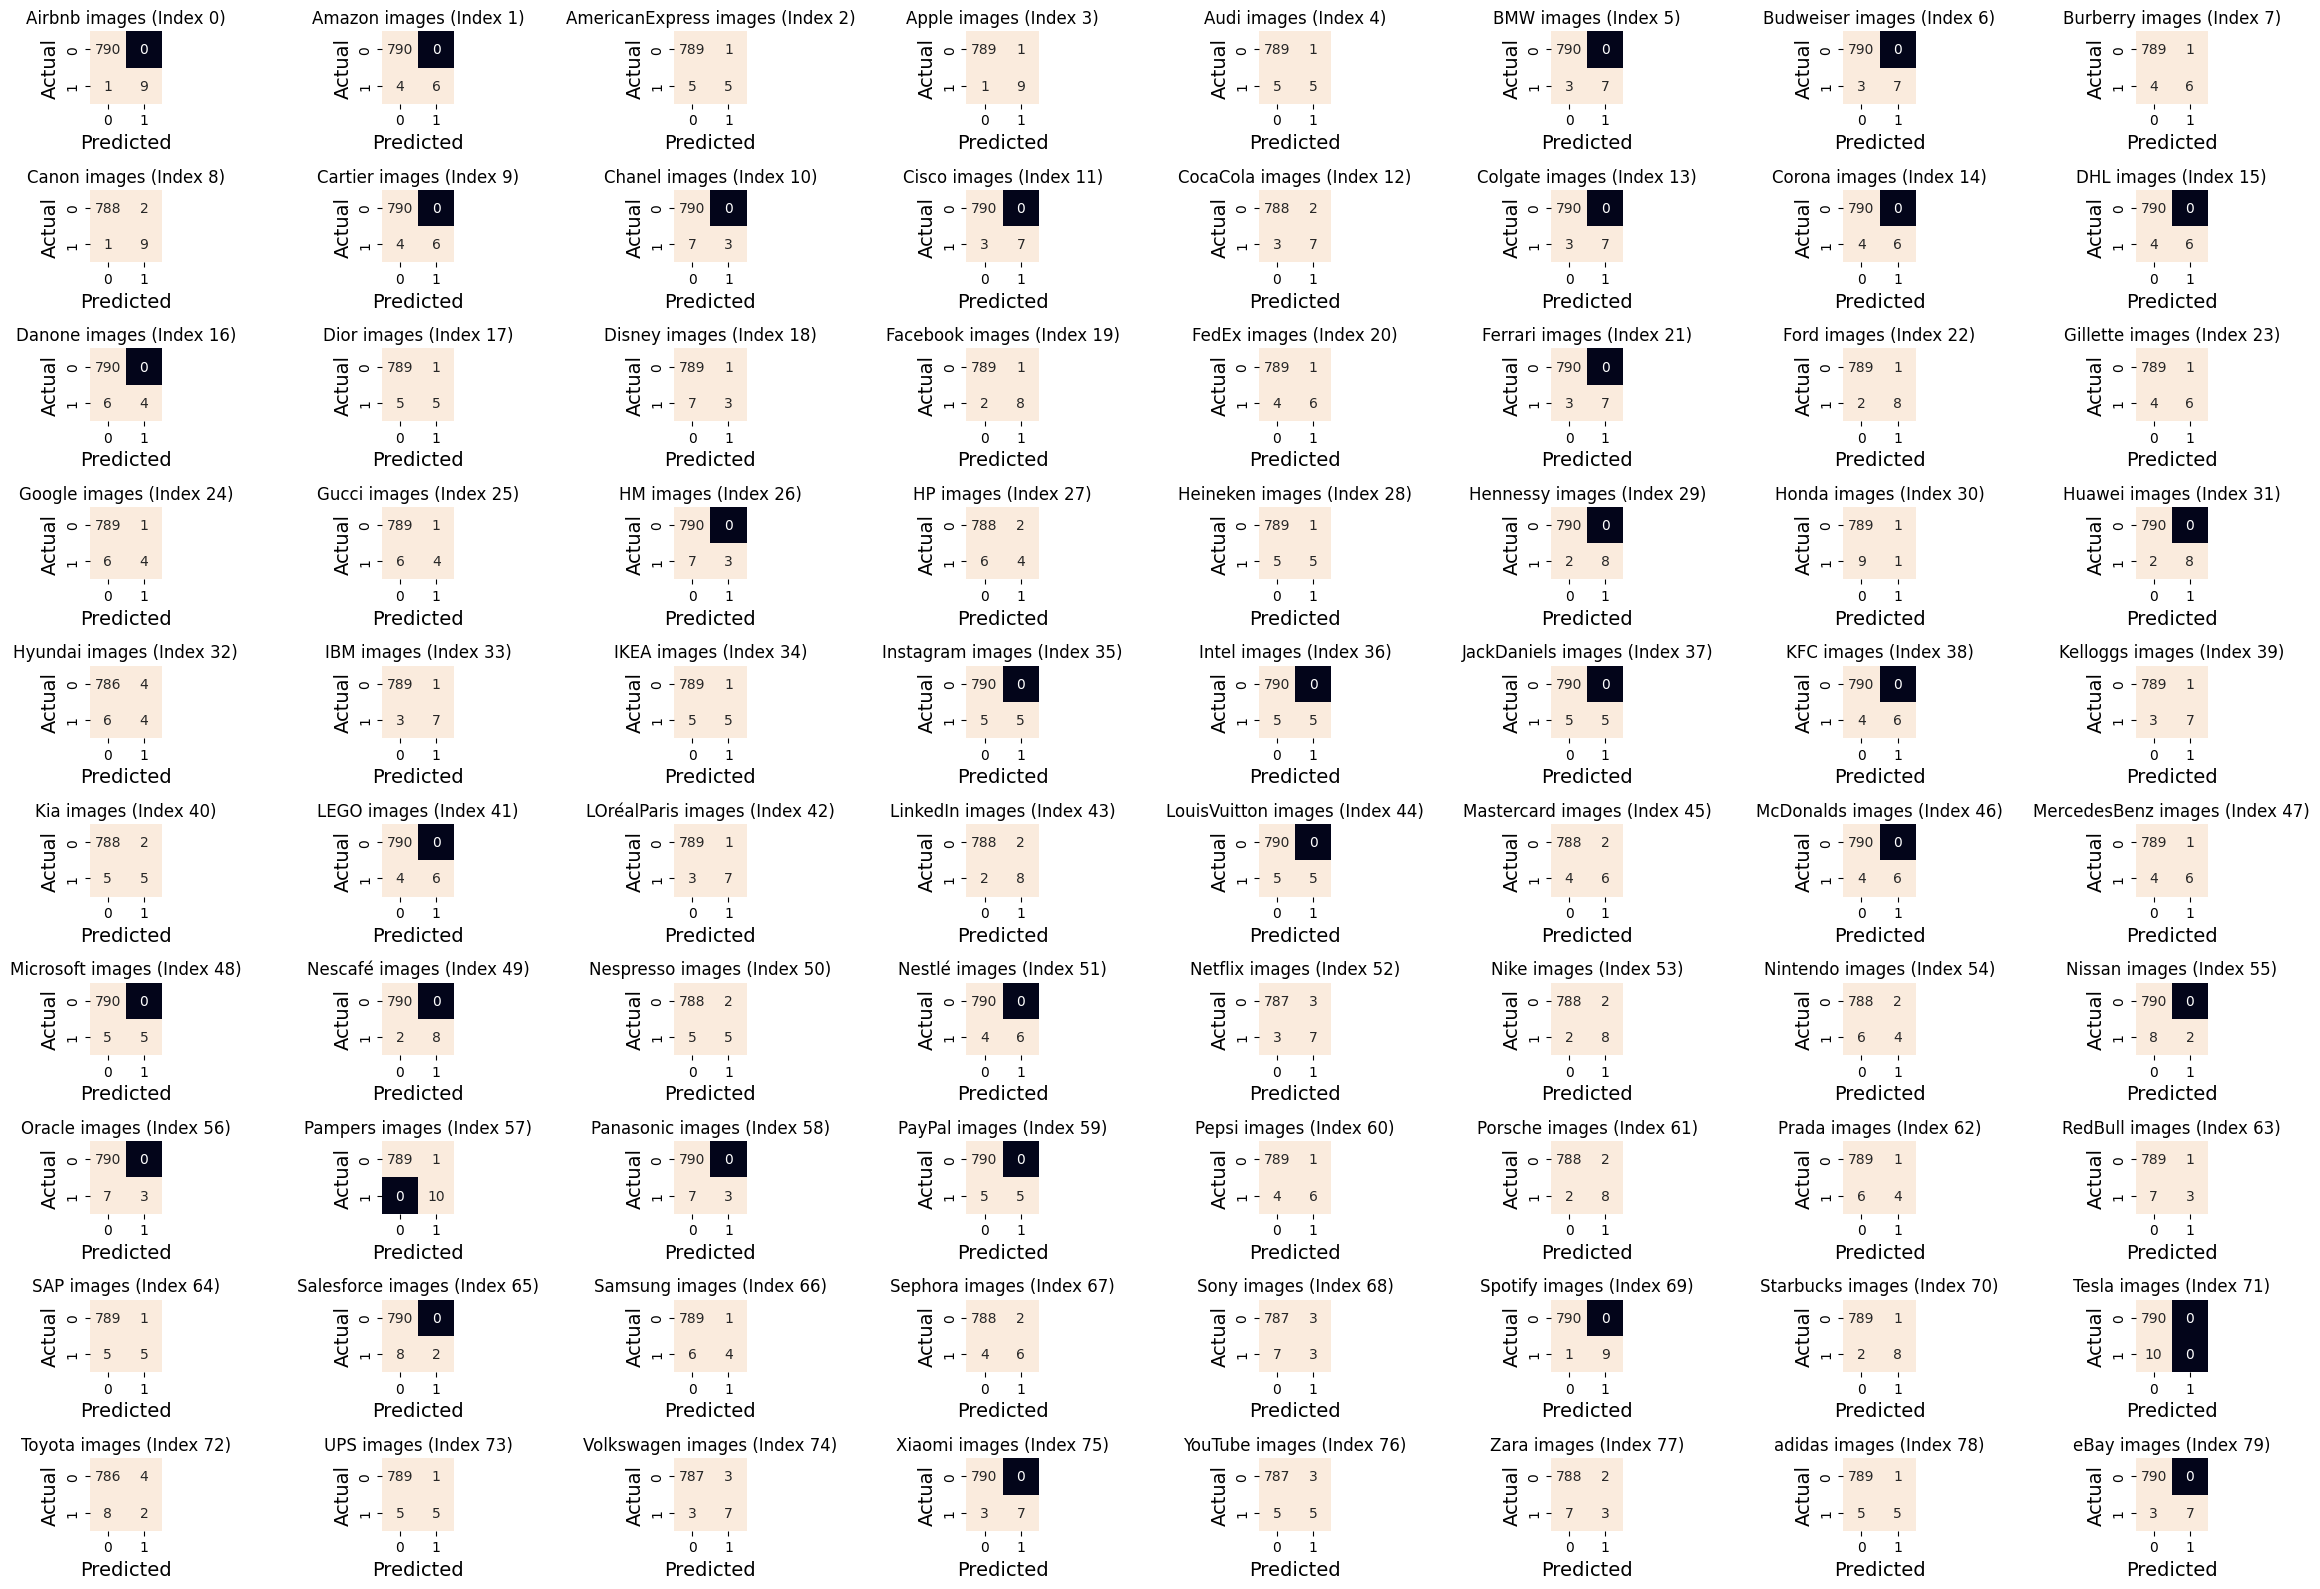

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you already have the reverse index mapping: idx_to_label
mxs_0 = mxs[0]
# Calculate number of rows and columns for the subplots (80 matrices)
n_rows = 10  # You can adjust this for different grid sizes
n_cols = 8   # Adjusted to fit 80 matrices in a grid

# Set up the matplotlib figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 16))  # Adjust the size as needed
axes = axes.ravel()  # Flatten the axes array to index them easily

# Plot each confusion matrix
for i, mx in enumerate(mxs_0):
    ax = axes[i]
    
    # Plot the heatmap with masked zeros
    sns.heatmap(mx, annot=True, fmt='d', vmin=0.5, vmax=1, cbar=False, ax=ax, square=True)
    
    # Set title with the index and label name
    label_name = idx_to_label.get(i, f"Label {i}")  # Get the label name or default to "Label i"
    ax.set_title(f'{label_name} (Index {i})')
    ax.set_xlabel('Predicted', fontsize=14)
    ax.set_ylabel('Actual', fontsize=14)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## Bayesian optimization

In [ ]:
# Define the objective function for Bayesian Optimization
def objective(batch_size, lr):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
    val_losses = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(train_dataset)))):
        # Split the dataset into train and validation sets
        train_subset = torch.utils.data.Subset(train_dataset, train_idx)
        val_subset = torch.utils.data.Subset(train_dataset, val_idx)
    
        # Create Data Module for each fold
        data_module = MyDataModule(train_subset, val_subset, batch_size, num_workers=2, persistent_workers=True)
        # Setup the model
        model = ResNetWrapper(dropout_rate=dropout_rate, lr=lr, sigmoid_threshold=0.4796)


            # Logger
        logger = TensorBoardLogger("lightning_logs", name=f"multilabel_training_fold_{fold}")

        # ModelCheckpoint to save only the best models
        checkpoint_callback = ModelCheckpoint(
            monitor="val_loss",
            mode="min",  # Minimize the val_loss
            save_top_k=1,  # Save only the best model
            filename="{epoch}-{val_loss:.2f}"
        )

        # EarlyStopping based on validation loss
        early_stopping = EarlyStopping(
            monitor="val_loss", 
            patience=3, 
            mode="min"
        )

        # Setup the Trainer
        trainer = Trainer(
            logger=logger,
            max_epochs=15,
            accelerator="gpu",  # Use "gpu" or "tpu" based on availability
            callbacks=[early_stopping, checkpoint_callback]
        )

        # Train the model
        trainer.fit(model, datamodule=data_module)

        # Get the validation loss (you need to log it properly during validation_step)
        if "val_loss" in trainer.callback_metrics:
            val_loss = trainer.callback_metrics["val_loss"].item()
        else:
            val_loss = float('inf')  # Or some default high value

        val_losses.append(val_loss)

    return -val_loss  # Return negative val_loss to maximize

# Define the search space
pbounds = {
    'batch_size': (16, 64),  # Memória függvényében növelheted 128-ig
    'lr': (0.001, 0.01)
}
# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# Run the optimization
optimizer.maximize(
    init_points=5,  # Number of initial random evaluations
    n_iter=5  # Number of optimization iterations
)

|   iter    |  target   | batch_... | dropou... |
-------------------------------------------------


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 10: 100%|██████████| 230/230 [02:05<00:00,  1.83it/s, v_num=1, val_loss=0.0322, val_acc=0.993, val_precision=0.865, val_recall=0.480, val_f1=0.617]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 9: 100%|██████████| 230/230 [07:44<00:00,  0.50it/s, v_num=1, val_loss=0.0359, val_acc=0.992, val_precision=0.849, val_recall=0.430, val_f1=0.571] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 10: 100%|██████████| 230/230 [02:03<00:00,  1.86it/s, v_num=1, val_loss=0.0347, val_acc=0.992, val_precision=0.846, val_recall=0.455, val_f1=0.592]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 10: 100%|██████████| 230/230 [02:03<00:00,  1.86it/s, v_num=1, val_loss=0.0349, val_acc=0.993, val_precision=0.890, val_recall=0.461, val_f1=0.607]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 10: 100%|██████████| 230/230 [10:55<00:00,  0.35it/s, v_num=1, val_loss=0.035, val_acc=0.992, val_precision=0.867, val_recall=0.459, val_f1=0.600] 
| 1         | -0.03501  | 33.98     | 0.4803    |


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 12: 100%|██████████| 230/230 [19:31<00:00,  0.20it/s, v_num=2, val_loss=0.0313, val_acc=0.993, val_precision=0.893, val_recall=0.483, val_f1=0.627] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 10: 100%|██████████| 230/230 [46:48<00:00,  0.08it/s, v_num=2, val_loss=0.0328, val_acc=0.993, val_precision=0.864, val_recall=0.485, val_f1=0.621]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 11: 100%|██████████| 230/230 [02:04<00:00,  1.84it/s, v_num=2, val_loss=0.0329, val_acc=0.993, val_precision=0.852, val_recall=0.491, val_f1=0.623]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 11: 100%|██████████| 230/230 [02:06<00:00,  1.81it/s, v_num=2, val_loss=0.0329, val_acc=0.993, val_precision=0.884, val_recall=0.479, val_f1=0.621]  


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 12: 100%|██████████| 230/230 [02:04<00:00,  1.85it/s, v_num=2, val_loss=0.0312, val_acc=0.993, val_precision=0.881, val_recall=0.514, val_f1=0.649]  
| 2         | -0.03119  | 51.14     | 0.3395    |


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 13: 100%|██████████| 230/230 [02:03<00:00,  1.86it/s, v_num=3, val_loss=0.0312, val_acc=0.993, val_precision=0.852, val_recall=0.523, val_f1=0.648]  


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 12: 100%|██████████| 230/230 [02:04<00:00,  1.84it/s, v_num=3, val_loss=0.0324, val_acc=0.993, val_precision=0.833, val_recall=0.520, val_f1=0.640]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 12: 100%|██████████| 230/230 [02:07<00:00,  1.81it/s, v_num=3, val_loss=0.0308, val_acc=0.993, val_precision=0.842, val_recall=0.540, val_f1=0.658]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 10: 100%|██████████| 230/230 [02:07<00:00,  1.81it/s, v_num=3, val_loss=0.0309, val_acc=0.993, val_precision=0.837, val_recall=0.510, val_f1=0.634]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 11: 100%|██████████| 230/230 [02:04<00:00,  1.85it/s, v_num=3, val_loss=0.030, val_acc=0.993, val_precision=0.846, val_recall=0.539, val_f1=0.659] 
| 3         | -0.03002  | 23.49     | 0.1624    |


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 9: 100%|██████████| 230/230 [02:03<00:00,  1.86it/s, v_num=4, val_loss=0.0323, val_acc=0.992, val_precision=0.874, val_recall=0.461, val_f1=0.604]  


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 9: 100%|██████████| 230/230 [02:07<00:00,  1.81it/s, v_num=4, val_loss=0.035, val_acc=0.992, val_precision=0.895, val_recall=0.438, val_f1=0.588]    


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 9: 100%|██████████| 230/230 [02:07<00:00,  1.81it/s, v_num=4, val_loss=0.0326, val_acc=0.993, val_precision=0.877, val_recall=0.476, val_f1=0.617]   


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 10: 100%|██████████| 230/230 [02:05<00:00,  1.83it/s, v_num=4, val_loss=0.0341, val_acc=0.993, val_precision=0.885, val_recall=0.466, val_f1=0.611]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 11: 100%|██████████| 230/230 [02:04<00:00,  1.85it/s, v_num=4, val_loss=0.0319, val_acc=0.993, val_precision=0.873, val_recall=0.514, val_f1=0.647]
| 4         | -0.03194  | 18.79     | 0.4465    |


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 10: 100%|██████████| 230/230 [02:05<00:00,  1.83it/s, v_num=5, val_loss=0.033, val_acc=0.992, val_precision=0.857, val_recall=0.473, val_f1=0.610] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 10: 100%|██████████| 230/230 [25:29<00:00,  0.15it/s, v_num=5, val_loss=0.0322, val_acc=0.993, val_precision=0.856, val_recall=0.493, val_f1=0.626]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 12: 100%|██████████| 230/230 [02:03<00:00,  1.86it/s, v_num=5, val_loss=0.0334, val_acc=0.993, val_precision=0.865, val_recall=0.479, val_f1=0.617]   


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 11: 100%|██████████| 230/230 [02:04<00:00,  1.85it/s, v_num=5, val_loss=0.033, val_acc=0.993, val_precision=0.859, val_recall=0.480, val_f1=0.616]   


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 12: 100%|██████████| 230/230 [02:06<00:00,  1.82it/s, v_num=5, val_loss=0.0327, val_acc=0.993, val_precision=0.878, val_recall=0.517, val_f1=0.651]  
| 5         | -0.0327   | 44.85     | 0.3832    |


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 12: 100%|██████████| 230/230 [02:05<00:00,  1.83it/s, v_num=6, val_loss=0.0315, val_acc=0.993, val_precision=0.866, val_recall=0.511, val_f1=0.643]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 10: 100%|██████████| 230/230 [02:06<00:00,  1.82it/s, v_num=6, val_loss=0.0344, val_acc=0.992, val_precision=0.886, val_recall=0.458, val_f1=0.604]  


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 10: 100%|██████████| 230/230 [02:06<00:00,  1.82it/s, v_num=6, val_loss=0.0329, val_acc=0.992, val_precision=0.860, val_recall=0.474, val_f1=0.611]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 12: 100%|██████████| 230/230 [18:19<00:00,  0.21it/s, v_num=6, val_loss=0.0342, val_acc=0.993, val_precision=0.877, val_recall=0.480, val_f1=0.620]  


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 11: 100%|██████████| 230/230 [02:06<00:00,  1.82it/s, v_num=6, val_loss=0.0322, val_acc=0.993, val_precision=0.892, val_recall=0.496, val_f1=0.638]
| 6         | -0.0322   | 25.87     | 0.4023    |


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 14: 100%|██████████| 230/230 [02:07<00:00,  1.80it/s, v_num=7, val_loss=0.0307, val_acc=0.993, val_precision=0.830, val_recall=0.545, val_f1=0.658]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 9: 100%|██████████| 230/230 [02:06<00:00,  1.82it/s, v_num=7, val_loss=0.032, val_acc=0.992, val_precision=0.817, val_recall=0.507, val_f1=0.626] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 12: 100%|██████████| 230/230 [02:06<00:00,  1.82it/s, v_num=7, val_loss=0.0311, val_acc=0.993, val_precision=0.827, val_recall=0.518, val_f1=0.637]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 11: 100%|██████████| 230/230 [02:06<00:00,  1.82it/s, v_num=7, val_loss=0.0312, val_acc=0.993, val_precision=0.845, val_recall=0.497, val_f1=0.626]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 10: 100%|██████████| 230/230 [02:07<00:00,  1.81it/s, v_num=7, val_loss=0.0296, val_acc=0.993, val_precision=0.825, val_recall=0.526, val_f1=0.642] 
| 7         | -0.02963  | 23.41     | 0.1228    |


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 13: 100%|██████████| 230/230 [4:03:42<00:00,  0.02it/s, v_num=8, val_loss=0.029, val_acc=0.993, val_precision=0.856, val_recall=0.542, val_f1=0.664]   


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 12: 100%|██████████| 230/230 [02:07<00:00,  1.80it/s, v_num=8, val_loss=0.0328, val_acc=0.993, val_precision=0.828, val_recall=0.516, val_f1=0.636]   


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 12: 100%|██████████| 230/230 [02:06<00:00,  1.82it/s, v_num=8, val_loss=0.0312, val_acc=0.993, val_precision=0.855, val_recall=0.520, val_f1=0.646]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 12: 100%|██████████| 230/230 [02:06<00:00,  1.81it/s, v_num=8, val_loss=0.0308, val_acc=0.993, val_precision=0.837, val_recall=0.532, val_f1=0.650]  


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 10: 100%|██████████| 230/230 [02:05<00:00,  1.83it/s, v_num=8, val_loss=0.0299, val_acc=0.993, val_precision=0.850, val_recall=0.522, val_f1=0.647]
| 8         | -0.02991  | 22.87     | 0.1759    |


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 10: 100%|██████████| 230/230 [18:15<00:00,  0.21it/s, v_num=9, val_loss=0.0295, val_acc=0.993, val_precision=0.862, val_recall=0.515, val_f1=0.645]    


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 10: 100%|██████████| 230/230 [18:11<00:00,  0.21it/s, v_num=9, val_loss=0.031, val_acc=0.993, val_precision=0.842, val_recall=0.519, val_f1=0.642]    


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Epoch 1:  82%|████████▏ | 189/230 [02:22<00:30,  1.33it/s, v_num=9, val_loss=0.0647, val_acc=0.988, val_precision=0.000, val_recall=0.000, val_f1=0.000]


Detected KeyboardInterrupt, attempting graceful shutdown ...
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/beszabo/Library/Python/3.9/lib/python/site-packages/bayes_opt/target_space.py", line 191, in probe
    target = self._cache[_hashable(x)]
KeyError: (21.789441973084273, 0.10333564000160314)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/beszabo/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/call.py", line 47, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "/Users/beszabo/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/trainer.py", line 575, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/Users/beszabo/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/trainer.py", line 982, in _run
    results = self._run_stage()
  File "/Users/beszabo/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/trainer.py", line 1026, in _run_stage
    self.fit_loo

In [ ]:
# Print the best parameters
best_params = optimizer.max['params']
best_params['batch_size'] = int(best_params['batch_size'])
print("Best parameters: ", best_params)
 # 0.00732   | 0.4592  val_f1= 0.461
# | 0.007323  | 0.4796    val_f1=0.528

In [ ]:
print(f"Best threshold: {optimizer.max['params']['threshold']:.4f}")
print(f"Best validation loss: {-optimizer.max['target']:.4f}")

## Download

In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))
download_file('/kaggle/working/', 'out')

In [ ]:
!zip -r file.zip /kaggle/working/lightning_logs/training_proper_test
from IPython.display import FileLink
FileLink(r'file.zip')

## Testing on the labeled logo dataset

In [ ]:
!ls lightning_logs/training_proper_test/version_24/checkpoints/

In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix

metric = MulticlassConfusionMatrix(num_classes=5)
metric.update(all_labels, all_preds)
fig_, ax_ = metric.plot()

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score
from glob import glob

# Assuming your test dataset is set up already
batch_size = 23
lr = 0.008274600824983372

# Create the test DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Find all checkpoint files recursively across all versions
checkpoint_directory = '/kaggle/working/lightning_logs/multilabel_training_fold_2/'
checkpoint_files = glob(os.path.join(checkpoint_directory, '**', '*.ckpt'), recursive=True)

# Define a dictionary to store the performance of each checkpoint
checkpoint_performance = {}

# Iterate through each checkpoint file
for checkpoint in checkpoint_files:
    # Load the model from checkpoint
    model = best_model
    model.eval()  
    model.to('cuda')

    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    # Evaluate model
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            # Get model predictions
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probabilities, 1)

            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update accuracy
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate F1 score and accuracy
    f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = 100 * correct / total

    # Store the performance metrics for the current checkpoint
    checkpoint_performance[checkpoint] = {'f1_score': f1, 'accuracy': accuracy}

    # Print results
    print(f"Checkpoint: {checkpoint}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.2f}%\n")

# Find the best checkpoint based on F1 score
best_checkpoint = max(checkpoint_performance, key=lambda x: checkpoint_performance[x]['f1_score'])
best_f1_score = checkpoint_performance[best_checkpoint]['f1_score']
best_accuracy = checkpoint_performance[best_checkpoint]['accuracy']

print("\nBest Checkpoint:")
print(f"Path: {best_checkpoint}")
print(f"F1 Score: {best_f1_score:.4f}")
print(f"Accuracy: {best_accuracy:.2f}%")


In [ ]:
import matplotlib.pyplot as plt
import torch

# Function to unnormalize images for display
def unnormalize(img_tensor, mean, std):
    img_tensor = img_tensor.clone()  # Clone the tensor to avoid modifying the original
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)  # Unnormalize each channel
    return img_tensor

# Define mean and std from your transform for unnormalizing
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Create a function to plot a grid of images
def plot_image_grid(dataset, num_images=16):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # Grid of 4x4 for 16 images
    axes = axes.flatten()

    for i in range(num_images):
        img, label = dataset[i]
        img = unnormalize(img, mean, std)  # Unnormalize
        img = img.permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize some images from the training dataset
plot_image_grid(test_set, num_images=16)


In [ ]:
import os
import glob


# Define the threshold for classification
threshold = 0.8
batch_size = 23
lr = 0.008274600824983372

# Initialize the trainer
trainer = Trainer()

results = []
checkpoint = "/kaggle/input/checkpoints/lightning_logs/the training/version_4/checkpoints/epoch=8-val_loss=1.39.ckpt"

# Load the test dataset
test_dataset = ImageFolder(root='/kaggle/input/brand-logos/test', transform=transform)

# Create the test DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Load the model from the checkpoint
model = ResNetWrapper.load_from_checkpoint(checkpoint, lr=lr, num_classes=100, 
                                            backbone_weights=models.ResNet50_Weights.IMAGENET1K_V2)
print(isinstance(model, LightningModule))
model.eval()  # Set model to evaluation mode if necessary

# Test the model using the Trainer
test_results = trainer.test(model, test_loader)

# Process the test results to compute thresholds if needed
preds = test_results[0]['preds']
labels = test_results[0]['labels']

# Convert logits to probabilities and apply thresholding
probabilities = F.softmax(preds, dim=1)
predicted = (probabilities > threshold).long().max(dim=1)[1]

# Store results
accuracy = (predicted == labels).sum().item() / len(labels)
results.append({'checkpoint': checkpoint, 'accuracy': accuracy})

# Output all results
for result in results:
    print(f"Checkpoint: {result['checkpoint']} - Accuracy: {result['accuracy']:.4f}")


In [ ]:
overall_f1_macro = f1_score(all_labels, all_preds, average='macro')   # Macro-average
print(overall_f1_macro)

### Saving best models

In [ ]:

!ls /kaggle/working/checkpoints/lightning_logs/
!ls /kaggle/working/checkpoints/lightning_logs/version_6/checkpoints
!zip -r nyertes.zip /kaggle/working/checkpoints/lightning_logs/version_13/checkpoints/epoch=14-step=2190.ckpt


In [ ]:
!zip -r version_5.zip /kaggle/working/checkpoints/lightning_logs/

In [ ]:
!pip install -U ipywidgets
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension


In [ ]:
!rm -rf /kaggle/working/*

## Test on unlabeled marketing memes

In [ ]:
import os
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
# Define your brand names in the order they appear in your list
brand_names = [
    "3m", "axa", "accenture", "adobe", "airbnb", "allianz", "amazon", "americanexpress", 
    "apple", "audi", "bmw", "budweiser", "burberry", "canon", "cartier", "caterpillar", 
    "chanel", "cisco", "citi bank", "cocacola", "colgate", "corona", "dhl", "danone", 
    "dior", "disney", "facebook", "fedex", "ferrari", "ford", "ge", "gillette", 
    "goldmansachs", "google", "gucci", "hm", "hp", "hsbc", "heineken", "hennessy", 
    "hermès", "hewlettpackardenterprise", "honda", "huawei", "hyundai", "ibm", "ikea", 
    "instagram", "intel", "jpmorgan", "jackdaniels", "johnsonjohnson", "kfc", "kelloggs", 
    "kia", "lego", "loréalparis", "linkedin", "louisvuitton", "mastercard", "mcdonalds", 
    "mercedesbenz", "microsoft", "morganstanley", "nescafé", "nespresso", "nestlé", 
    "netflix", "nike", "nintendo", "nissan", "oracle", "pampers", "panasonic", "paypal", 
    "pepsi", "philips", "porsche", "prada", "redbull", "sap", "salesforce", "samsung", 
    "santander", "sephora", "siemens", "sony", "spotify", "starbucks", "tesla", 
    "tiffanyco", "toyota", "ups", "visa", "volkswagen", "xiaomi", "youtube", "zara", 
    "adidas", "ebay"
]

class UnlabeledImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.lower().endswith(('png', 'jpg', 'jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path


# Load the model checkpoint
num_classes = 100  # Adjust based on your actual number of classes
model = ResNetWrapper.load_from_checkpoint(checkpoint,lr=lr, num_classes=num_classes, backbone_weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50 typically takes 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the prediction function
def classify_images(model, image_folder, transform, device):
    dataset = UnlabeledImageDataset(image_folder, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    results = {}  # Ensure 'results' dictionary is initialized

    with torch.no_grad():
        for images, img_paths in dataloader:
            images = images.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
            confidences, preds = torch.max(probs, dim=1)  # Get the highest probability and its index for each prediction

            for confidence, pred, img_path in zip(confidences, preds, img_paths):
                if confidence.item() >= 0.9:  # Only consider predictions with confidence >= 80%
                    brand = brand_names[pred.item()].lower()  # Map index to brand name

                    if brand not in results:
                        results[brand] = []
                    results[brand].append(os.path.basename(img_path))  # Append the filename, not the full path

    return results

# Define the folder containing images to classify
image_folder = "/kaggle/input/5memes-for-top-100-most-valuable-brand-2023"

# Classify images and store the results in a dictionary
dict1 = classify_images(model, image_folder, transform, device)


# Classify images and store the results in a dictionary
dict1 = classify_images(model, image_folder, transform, device)
dict2 = {'apple': ['Xiaomi memes_9daf00f7-8607-4ff6-b8e1-1dd5c755f43a.jpeg', 'Apple memes_iphone-chatgpt.jpg', 'Apple memes_Image_2.jpg', 'Huawei memes_Image_3.jpg'], 'microsoft': ['Microsoft memes_Image_5.jpg', 'Microsoft memes_Image_1.jpeg', 'Microsoft memes_Image_4.jpeg', 'HP memes_190d521ac62eaf40a74e50ab39635231.jpg'], 'amazon': ['Amazon memes_Image_1.jpg', 'Amazon memes_Image_2.jpg', 'Amazon memes_Image_4.jpeg', 'Amazon memes_Image_5.jpg', 'Amazon memes_Image_3.jpg'], 'google': ['Google memes_Image_2.jpeg', 'Google memes_Image_1.jpg', 'Xiaomi memes_Image_2.jpeg', 'Google memes_Image_4.jpg', 'Google memes_Image_3.jpg'], 'samsung': ['Samsung memes_Image_1.jpeg', 'Samsung memes_Image_2.jpg', 'Samsung memes_Image_3.jpg', 'Samsung memes_Image_4.jpg', 'Samsung memes_Image_5.jpeg'], 'toyota': ['Toyota memes_Image_1.jpg', 'Toyota memes_Image_2.jpg', 'Toyota memes_Image_4.jpg'], 'mercedes-benz': ['MercedesBenz memes_Image_5.jpg', 'MercedesBenz memes_Image_3.jpg'], 'coca-cola': ['CocaCola memes_Image_2.jpeg', 'Pepsi memes_Image_3.jpg', 'CocaCola memes_Image_1.jpg'], 'nike': [], 'bmw': ['BMW memes_ayNdM3q_460s.jpg', 'BMW memes_Image_4.jpg', 'Audi memes_Image_5.jpg', 'MercedesBenz memes_Image_1.jpg'], "mcdonald's": ['McDonalds memes_Image_2.jpg', 'McDonalds memes_Image_1.jpg', 'McDonalds memes_Image_2 (copy 1).jpg'], 'tesla': ['Tesla memes_Image_2.jpg', 'Tesla memes_teslamemes-191110030713-thumbnail.webp', 'Caterpillar memes_image-1.webp', 'Tesla memes_Image_5.jpg'], 'disney': ['Disney memes_Image_1.png', 'Disney memes_Image_2.jpg', 'Disney memes_relatable-disney-memes.png'], 'louis vuitton': ['LouisVuitton memes_Image_1.jpg', 'LouisVuitton memes_tgeycyn3z4k91.jpg', 'LouisVuitton memes_0a2163e267c3e9c175e7c08bf8253318.jpg', 'LouisVuitton memes_Image_2.jpg'], 'cisco': ['Cisco memes_d77c72918e7440d37fc3eabc307ad8ac3a8025383ea34cdb6e1df27c047628f6_1.jpg', 'Cisco memes_Image_3.jpg', 'Cisco memes_Image_1.jpg', 'Cisco memes_fc0j9uamxd371.png'], 'instagram': ['Instagram memes_Image_4.jpg', 'Instagram memes_ig.jpg', 'Heineken memes_Image_1.jpg', 'Instagram memes_Image_5.jpg', 'Airbnb memes_Image_1.jpg', 'Instagram memes_person-women-on-instagram-be-like-got-new-shoes.jpeg', 'Instagram memes_Image_2.jpg', 'HewlettPackardEnterprise memes_EPo6d7mUYAAHsU0.jpg'], 'adobe': ['Adobe memes_Image_3.jpeg', 'Adobe memes_Image_1.jpeg', 'Adobe memes_Image_2.jpeg'], 'ibm': ['IBM memes_Image_2.jpg', 'IBM memes_Image_1.jpg', 'IBM memes_Image_3.jpg'], 'oracle': ['Oracle memes_EXT38P1WkAAjs_5.jpg', 'Oracle memes_Image_5.jpg', 'Oracle memes_programmerhumor-io-databases-memes-backend-memes-ce04a4d894b6035-608x613.webp'], 'sap': ['SAP memes_Image_1.jpeg', 'SAP memes_Image_3.jpg', 'SAP memes_Image_5.png', 'SAP memes_Image_2.jpeg', 'SAP memes_Image_4.jpg'], 'facebook': ['Instagram memes_Image_4.jpg', 'Heineken memes_Image_1.jpg', 'Caterpillar memes_Bj9v-r7IUAApml9.png', 'Facebook memes_Image_1.jpg', 'Facebook memes_Screenshot2021-11-01at16.29.20.jpg', 'TiffanyCo memes_98facae07556bfaab7cb6672371ff06c.jpg', 'Facebook memes_f.jpg', 'Facebook memes_Image_4.jpg', 'HewlettPackardEnterprise memes_EPo6d7mUYAAHsU0.jpg'], 'chanel': ['Chanel memes_images (1).jpeg', 'Chanel memes_Screen-Shot-2021-04-29-at-8.webp', 'Chanel memes_Image_2.jpg', 'Chanel memes_images.jpeg'], 'hermes': ['Herms memes_434053634_18427064311043375_1898595488137274113_n.jpg', 'Herms memes_Fd_gt0bUUAAeCRh.jpg'], 'intel': ['Intel memes_Image_4 (copy 1).jpeg', 'Intel memes_Image_2.jpg', 'Intel memes_Image_4.jpeg', 'Intel memes_Image_1.jpg'], 'youtube': ['YouTube memes_Image_2.jpg', 'YouTube memes_Image_3.jpg'], 'j.p. morgan': ['JPMorgan memes_xq0z4545oqe41.webp', 'MorganStanley memes_Image_1.jpg'], 'honda': ['Honda memes_Image_4.jpg', 'Honda memes_Image_5.jpg'], 'american express': ['AmericanExpress memes_Image_3.jpg', 'AmericanExpress memes_Image_4.jpg', 'AmericanExpress memes_Image_1.jpg'], 'ikea': ['IKEA memes_Image_3.jpg', 'IKEA memes_Image_5.png', 'IKEA memes_Image_2.jpg', 'IKEA memes_Image_4.jpg'], 'accenture': ['Accenture memes_Image_4.jpg', 'Accenture memes_Image_1.png', 'Accenture memes_Image_2.jpg', 'Accenture memes_Image_5.jpg'], 'allianz': ['Allianz memes_amLOMzj_460s.jpg', 'Allianz memes_Image_2.jpg', 'Allianz memes_Image_1.jpg', 'Allianz memes_images.jpeg'], 'hyundai': ['Hyundai memes_Image_3.jpeg', 'Hyundai memes_Image_4.jpg'], 'ups': ['Cisco memes_d77c72918e7440d37fc3eabc307ad8ac3a8025383ea34cdb6e1df27c047628f6_1.jpg', 'UPS memes_Image_4.jpg', 'Ferrari memes_Image_2.jpg', 'DHL memes_Image_2.jpeg', 'UPS memes_Image_3.jpeg', 'UPS memes_Image_2.jpeg'], 'gucci': ['Gucci memes_Image_3.jpg', 'Gucci memes_Image_1.jpg', 'Gucci memes_Image_2 (copy 1).jpg', 'Gucci memes_Image_2.jpg'], 'pepsi': ['Pepsi memes_Image_2.jpeg', 'Pepsi memes_Image_3.jpg', 'Pepsi memes_Image_5.jpeg'], 'sony': ['Sony memes_Image_2.jpg', 'Sony memes_Image_3.jpeg', 'Sony memes_Image_2 (copy 1).jpg', 'Sony memes_Image_1.jpeg'], 'visa': ['Visa memes_Image_3.jpg', 'AmericanExpress memes_Image_2.jpg', 'Visa memes_Image_2.jpg', 'Visa memes_Image_5.jpg', 'Visa memes_Image_4.jpg'], 'salesforce': ['Salesforce memes_Image_1.jpeg', 'Salesforce memes_Image_3.jpeg', 'Salesforce memes_Image_5.jpeg', 'Salesforce memes_Image_2.jpeg', 'Salesforce memes_Image_4.jpg'], 'netflix': ['Netflix memes_Image_4.jpg', 'Cisco memes_d77c72918e7440d37fc3eabc307ad8ac3a8025383ea34cdb6e1df27c047628f6_1.jpg', 'Netflix memes_Image_5.jpg', 'Netflix memes_Image_1.jpg'], 'paypal': ['PayPal memes_Image_4.jpeg', 'PayPal memes_Image_2.jpg', 'PayPal memes_Image_3.jpeg', 'PayPal memes_Image_1.jpeg'], 'mastercard': ['Mastercard memes_Image_2.jpg', 'Mastercard memes_Image_4.jpg', 'Mastercard memes_Image_1.jpeg', 'AmericanExpress memes_Image_2.jpg', 'Visa memes_Image_5.jpg'], 'adidas': ['adidas memes_Image_1.jpeg'], 'zara': ['Zara memes_Image_1.jpeg', 'Zara memes_Image_3.jpeg', 'Zara memes_Image_5.jpg'], 'axa': ['AXA memes_gettyimages-1226469012-612x612.jpg'], 'audi': ['Audi memes_Image_5.jpg', 'MercedesBenz memes_Image_1.jpg', 'Audi memes_Image_4.jpg'], 'airbnb': ['Airbnb memes_Image_3.png', 'Airbnb memes_Image_1.jpg', 'Airbnb memes_Image_4.jpeg', 'Airbnb memes_Image_2.jpg', 'Airbnb memes_P4BwmWt.jpg'], 'porsche': ['Porsche memes_Image_2.jpeg', 'Porsche memes_Image_1.jpg', 'Porsche memes_Image_4.jpg'], 'starbucks': ['Starbucks memes_Image_4.jpg', 'Starbucks memes_Image_2.png', 'Starbucks memes_4e59a310d37f67cbb82bcd067ee4e0c7.jpg', 'Starbucks memes_Image_3.png'], 'ge': ['GE memes_images (2).jpeg'], 'volkswagen': ['Volkswagen memes_Image_3.jpg', 'Volkswagen memes_Image_1.jpeg'], 'ford': ['Ford memes_Image_5.jpeg'], 'nescafé': [], 'siemens': ['Siemens memes_Image_5.jpg', 'Siemens memes_siemens-heh-heh-heh-v0-yf2fbabx814b1.webp', 'Siemens memes_Image_4.jpg', 'Siemens memes_A6Db4nQCQAEw2Xg.jpg'], 'goldman sachs': ['GoldmanSachs memes_Image_5.jpg', 'GoldmanSachs memes_Image_2.jpg', 'GoldmanSachs memes_Image_3.jpg', 'GoldmanSachs memes_Image_4.jpg'], 'pampers': ['Pampers memes_Image_3.jpg', 'Pampers memes_Image_5 (copy 1).jpg', 'Pampers memes_Image_5.jpg'], 'h&m': ['HM memes_tandem-x-visuals-FZOOxR2auVI-unsplash-1313x900.webp', 'HM memes_Image_4.jpeg'], 'l’oréal paris': ['LOralParis memes_Image_3.jpg', 'LOralParis memes_Image_1.jpg', 'LOralParis memes_Image_2.jpeg'], 'citi': ['Cisco memes_d77c72918e7440d37fc3eabc307ad8ac3a8025383ea34cdb6e1df27c047628f6_1.jpg', 'Citi Bank memes_Image_4.jpg', 'MorganStanley memes_Image_3.jpg', 'Citi Bank memes_citi.jpg', 'Citi Bank memes_Image_2.jpg', 'Citi Bank memes_Image_5.jpg'], 'lego': ['LEGO memes_Image_5.jpg', 'LEGO memes_images.jpeg', 'LEGO memes_Image_4.jpeg'], 'red bull': ['JackDaniels memes_Image_2.jpg', 'RedBull memes_Image_5.jpg', 'RedBull memes_Image_2.jpg', 'RedBull memes_Image_4.jpeg', 'RedBull memes_Image_3.jpg'], 'budweiser': ['Budweiser memes_Image_3.jpg', 'Budweiser memes_aoKL853_460s.jpg', 'Budweiser memes_Image_2.jpg', 'Budweiser memes_Image_4.jpg', 'Budweiser memes_Image_1.jpg'], 'ebay': ['eBay memes_Image_4.jpg', 'eBay memes_Image_2.jpg'], 'nissan': ['Nissan memes_Image_2.jpeg', 'Nissan memes_Image_4.jpg', 'Nissan memes_Image_3.jpeg', 'Nissan memes_Image_3.jpg'], 'hp': ['HewlettPackardEnterprise memes_k8m3z.jpg', 'HP memes_38ef2b77327f4020f04dc14dc41f1538.jpg', 'HP memes_190d521ac62eaf40a74e50ab39635231.jpg'], 'hsbc': ['HSBC memes_Image_1.jpg', 'HSBC memes_Image_3.jpg', 'HSBC memes_images.jpeg'], 'morgan stanley': ['MorganStanley memes_4521ccf691de4bacef41ccbb143387b2.jpg', 'MorganStanley memes_Image_4.jpg', 'MorganStanley memes_images.jpeg', 'MorganStanley memes_Image_1.jpg'], 'nestle': ['Nestl memes_Image_1.jpeg', 'Nestl memes_Image_2.jpeg', 'Nestl memes_Image_3.jpeg', 'Nestl memes_Image_4.jpeg', 'Nestl memes_Image_5.jpg'], 'philips': ['Philips memes_Image_4.jpeg', 'Philips memes_images.jpeg', 'Philips memes_Philips-Innovationandyou-1002x1417.jpg', 'Philips memes_unnamed.jpg'], 'spotify': ['Spotify memes_spotify-now-listen-most-boring-pop-charts-yes-hey-xx-xx-tap-banner-now-last-ad-just-two-songs-ago.png', 'Spotify memes_Image_5.jpeg'], 'ferrari': ['Ferrari memes_Image_5.jpg', 'Ferrari memes_Image_1.jpg', 'Ferrari memes_Image_1.jpeg', 'Ferrari memes_Image_2.jpg', 'Ferrari memes_Image_3.png'], 'nintendo': ['Philips memes_Image_4.jpeg', 'Nintendo memes_Image_5.jpeg', 'Nintendo memes_Image_4.jpeg', 'Panasonic memes_Image_3.jpeg'], 'gillette': ['Gillette memes_Image_1.jpeg', 'Gillette memes_Image_2.jpg', 'Gillette memes_Image_4.jpeg', 'Gillette memes_Image_5.jpg'], 'colgate': ['Colgate memes_Image_4.jpeg', 'Colgate memes_Image_2.jpg', 'LOralParis memes_Image_2.jpeg'], 'cartier': ['Cartier memes_CaGpc-1VIAAOpWc.png', 'Cartier memes_Image_3.jpg', 'Cartier memes_Image_1.jpeg', 'Cartier memes_65c080cea63c4.jpeg'], '3m': ['3M memes_Image_2.jpg', '3M memes_Image_5.jpg', '3M memes_Image_3.jpg', '3M memes_khkn86l1vgs41.webp'], 'dior': ['Dior memes_Image_3.jpg', 'Dior memes_Image_5.jpg', 'Dior memes_Image_2.jpg', 'Dior memes_Image_4.jpeg', 'Dior memes_Image_4.jpg'], 'santander': ['Santander memes_Image_2.jpg', 'Santander memes_Image_3.jpg', 'Santander memes_Image_4.jpg', 'Santander memes_meme1.webp'], 'danone': ['Danone memes_Image_2.jpg', 'Danone memes_Image_3.jpg', 'Danone memes_5lmocm.jpg', 'Danone memes_5b1d46878de83.jpeg', 'Danone memes_page_1.webp'], "kellogg's": ['Kelloggs memes_Image_3.jpeg', 'Kelloggs memes_Image_3.jpg'], 'linkedin': ['LinkedIn memes_Image_2.jpg'], 'corona': ['Corona memes_om9ysstu92k41.jpg'], 'fedex': ['FedEx memes_Image_1.jpg', 'FedEx memes_Image_5.jpg', 'FedEx memes_Image_2.jpeg', 'FedEx memes_Image_3.jpg'], 'caterpillar': ['Caterpillar memes_image-1.webp'], 'dhl': ['DHL memes_Image_5.jpg', 'DHL memes_Image_4.png', 'DHL memes_Image_1.jpg', 'DHL memes_Image_2.jpeg'], "jack daniel's": ['JackDaniels memes_Image_4.jpg'], 'prada': ['Prada memes_highxtar-prada-ss21-campaign-4.jpg', 'Prada memes_highxtar-prada-ss21-campaign-1.jpg', 'Prada memes_DIETPRADA3.webp', 'Prada memes_highxtar-prada-ss21-campaign-2.jpg'], 'xiaomi': ['Xiaomi memes_9daf00f7-8607-4ff6-b8e1-1dd5c755f43a.jpeg', 'Xiaomi memes_Image_4.jpeg', 'Xiaomi memes_Image_1.jpeg'], 'kia': [], 'tiffany & co.': [], 'panasonic': ['Panasonic memes_Image_5.jpg', 'Panasonic memes_Image_4.jpeg', 'Panasonic memes_Image_1.jpeg'], 'hewlett packard enterprise': ['hp enterprise', 'hewlett packard', 'HewlettPackardEnterprise memes_maxresdefault.jpg', 'HewlettPackardEnterprise memes_EPo6d7mUYAAHsU0.jpg'], 'huawei': ['Huawei memes_Image_5.jpg', 'Huawei memes_u8978vigrj031.webp', 'Huawei memes_Image_3.jpg'], 'hennessy': ['Hennessy memes_Image_4.jpg', 'Hennessy memes_Image_3.jpg', 'Hennessy memes_Image_2.jpg', 'Hennessy memes_Image_1.jpg', 'Hennessy memes_Image_5.jpg'], 'burberry': ['Burberry memes_images.jpeg', 'Burberry memes_Image_3.jpg', 'Burberry memes_4febf2b9add2cf73f8e3bcca6f67c904.jpg', 'Burberry memes_Image_5.jpg'], 'kfc': ['KFC memes_Image_4.jpg', 'KFC memes_Image_1.jpeg', 'KFC memes_Image_5.jpeg', 'KFC memes_Image_2 (copy 1).jpg'], 'johnson & johnson': ['JohnsonJohnson memes_jj-vaccine-covid-19-vaccine-memes-covid-19-memes-funny-memes-memes-twitter-memes-funny-tweets.jpeg', 'JohnsonJohnson memes_memes-for-use-to-spam-j-j-v0-2kmhfpfrrmbb1.webp', 'JohnsonJohnson memes_Image_1.jpg'], 'sephora': ['Sephora memes_Image_5.png', 'Sephora memes_Image_2.jpg', 'Sephora memes_Image_1.jpg', 'Sephora memes_Image_4.jpeg', 'Sephora memes_Image_3.jpg'], 'nespresso': ['Nespresso memes_Image_3.jpg', 'Nespresso memes_Image_1.jpg', 'Nespresso memes_Image_2.jpg', 'Nespresso memes_Image_4.jpg', 'Nespresso memes_Image_5.jpg'], 'heineken': ['Corona memes_images.jpeg', 'Heineken memes_Image_1.jpg', 'Heineken memes_Image_5.jpg'], 'canon': ['Canon memes_55bc7be8031ed.jpeg', 'Canon memes_7ugwbf.jpg', 'Canon memes_Image_1.jpg', 'Canon memes_xzgpcaalz69a1.jpg']}
result = {}

for key in dict1:
    if key in dict2:
        if key not in result:
            result[key] = dict1[key] + dict2[key]
    else:
        result[key] = dict1[key]

for key in dict2:
    if key not in result:
        result[key] = dict2[key]
print("finished")

In [ ]:
for i, (key, value_list) in enumerate(dict1.items()):
    print(f"{i} \t {key}: {value_list}\n")

In [ ]:
result

Dagsub connection, authentication

In [ ]:
!rm -r /kaggle/working/

In [ ]:
!rm -fr /kaggle/working/DIRPATH/model-epoch=14-val_loss=1.60.ckpt